<a href="https://colab.research.google.com/github/diegoOrd123/Segundo-parcial/blob/main/breakoutv2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ale-py
import ale_py  # Import ale-py explicitly

In [1]:
import os
!pip install gymnasium[atari,accept-rom-license]
!pip install gymnasium[other]
os.environ["KERAS_BACKEND"] = "tensorflow"
from gym.wrappers import FrameStack, AtariPreprocessing
!pip install "gymnasium[atari,accept-rom-license]" --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 20.0 MB/s eta 0:00:00


In [3]:
!pip install FrameStack
from gym import error
from gym.wrappers.frame_stack import FrameStack, LazyFrames

  Preparing metadata (setup.py) ... done
  Created wheel for FrameStack: filename=framestack-0.1.0-py3-none-any.whl size=1134 sha256=295e860d8d10f122598342f7ce5ab277068f1fcd7f99493d1b58eea951b6ca60
  Stored in directory: /root/.cache/pip/wheels/39/74/a7/89f7f0c0edee713ded539856680b1af0b0b4e37459ff89f409
Successfully built FrameStack


In [4]:

import keras
from keras import layers

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
import numpy as np
import tensorflow as tf

# Configuration parameters for the whole setup
seed1 = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 100  # Limit training episodes, will run until solved if smaller than 1

# Use the Atari environment
# Specify the `render_mode` parameter to show the attempts of the agent in a pop up window.
env = gym.make("BreakoutNoFrameskip-v4")  # , render_mode="human")
# Environment preprocessing
env.action_space.seed(seed1)
env.observation_space.seed(seed1)
env = AtariPreprocessing(env, frame_skip=1, scale_obs=False)
# Stack four frames
env = FrameStack(env, 4)
def reset_with_stack(self, **kwargs):
    """
    Modified reset function to handle the tuple returned by AtariPreprocessing.
    """
    obs, info = self.env.reset(**kwargs)
    # Convert the tuple to a NumPy array
    obs = obs[0] if isinstance(obs, tuple) else obs
    for _ in range(self.num_stack):
        self.frames.append(obs)
    return self.observation(None), info

# Monkey-patch the reset function for the FrameStack instance
env.reset = reset_with_stack.__get__(env, FrameStack)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    return keras.Sequential(
        [
            layers.Lambda(
                lambda tensor: keras.ops.transpose(tensor, [0, 2, 3, 1]),
                output_shape=(84, 84, 4),
                input_shape=(4, 84, 84),
            ),
            # Convolutions on the frames on the screen
            layers.Conv2D(32, 8, strides=4, activation="relu", input_shape=(4, 84, 84)),
            layers.Conv2D(64, 4, strides=2, activation="relu"),
            layers.Conv2D(64, 3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(num_actions, activation="linear"),
        ]
    )


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
dqn_rewards = []
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:
    observation, _ = env.reset()
    state = np.array(observation)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = keras.ops.convert_to_tensor(state)
            state_tensor = keras.ops.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = keras.ops.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, info = env.step(action)

        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = keras.ops.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * keras.ops.amax(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = keras.ops.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
      # Actualizar la recompensa media del episodio
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)






    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
          del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

      # Guardar la recompensa media para graficar
    dqn_rewards.append(running_reward)

    episode_count += 1

      # Verificar si el agente ha resuelto la tarea
    if running_reward > 40:  # Condición para considerar que se resolvió la tarea
          print("Solved at episode {}!".format(episode_count))
          break

      # Limitar el número máximo de episodios
    if max_episodes > 0 and episode_count >= max_episodes:
          print("Stopped at episode {}!".format(episode_count))
          break





    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if (
        max_episodes > 0 and episode_count >= max_episodes
    ):  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

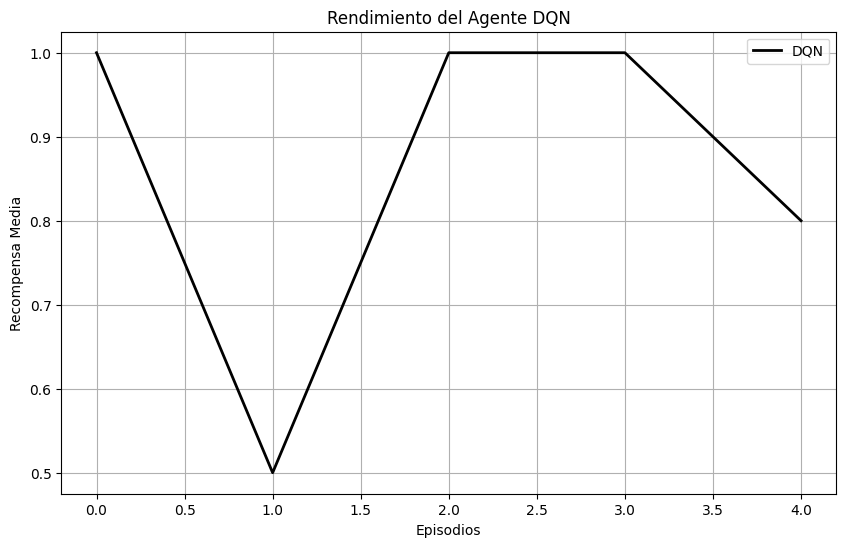

In [ ]:
import matplotlib.pyplot as plt

# Graficar las recompensas medias del agente DQN
plt.figure(figsize=(10, 6))
plt.plot(dqn_rewards, label="DQN", color="black", linewidth=2)
plt.legend()
plt.grid(True)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Media')
plt.title('Rendimiento del Agente DQN')
plt.show()